In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from class_cvae import ConditionalVariationalAutoEncoder

In [2]:
qpos = np.load('snapbot_data/forward.npy')
tpos = np.load('snapbot_data/forward.npy')
qpos = qpos[:100,:,:]
print("original qpos shape: {}".format(qpos.shape))

original qpos shape: (100, 101, 8)


In [3]:
train_q = torch.FloatTensor(qpos[:,::7,:].reshape(qpos.shape[0], -1))
train_t = torch.FloatTensor(tpos[:,::7,:].reshape(tpos.shape[0], -1))
print("train qpos shape: {}".format(train_q.shape))

train qpos shape: torch.Size([100, 120])


In [4]:
novel_qpos = np.load('snapbot_data/right.npy')
novel_q = torch.FloatTensor(novel_qpos[:,::7,:].reshape(novel_qpos.shape[0], -1))
print("novel qpos shape: {}".format(novel_q.shape))

novel qpos shape: torch.Size([1000, 120])


In [5]:
CVAE = ConditionalVariationalAutoEncoder(
        name     = 'DLPG',              
        x_dim    = 120,             # input dimension
        c_dim    = 0,               # condition dimension
        z_dim    = 2,               # latent dimension
        h_dims   = [64,32],         # hidden dimensions of encoder (and decoder)
        actv_enc = nn.ReLU(),       # encoder activation
        actv_dec = nn.ReLU(),       # decoder activation
        actv_out = None,            # output activation
        var_max  = None,            # maximum variance
        device   = 'cpu'
)

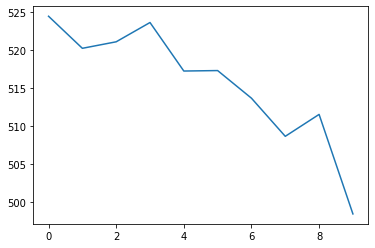

In [6]:
loss = CVAE.update(
                x = train_q,
                c = None,
                lr = 0.01,
                max_iter = 10,
                batch_size = 3
                )

plt.figure()
plt.plot(loss)
plt.show()

In [7]:
recon_loss = []
for i in range(1000):
    recon_q = CVAE.xc_to_x_recon(x=train_t[i], c=None)
    # recon_loss += F.mse_loss(recon_q, train_q[i])
    recon_loss.append(F.mse_loss(recon_q, train_t[i]).item())

original_uncertainty = np.array(recon_loss).reshape(-1,1)
original_uncertainty.shape


(1000, 1)

In [8]:
recon_loss = []
for i in range(1000):
    recon_q = CVAE.xc_to_x_recon(x=novel_q[i], c=None)
    # recon_loss += F.mse_loss(recon_q, novel_q[i])
    recon_loss.append(F.mse_loss(recon_q, novel_q[i]).item())
novelty_uncertainty = np.array(recon_loss).reshape(-1,1)
novelty_uncertainty.shape

(1000, 1)

In [9]:
total_uncertainty = np.concatenate((original_uncertainty, novelty_uncertainty),axis=0)

In [10]:
forward_label = np.zeros(1000)
novelty_label = np.ones(1000)
total_label   = np.concatenate((forward_label, novelty_label), axis=0)

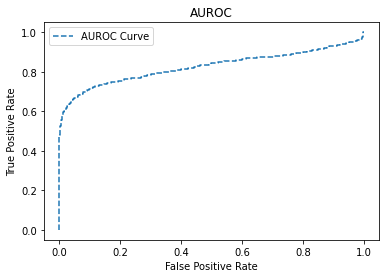

0.8254059999999999


In [11]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve,auc, roc_auc_score, roc_curve 

fpr, tpr, thresholds = metrics.roc_curve(total_label, total_uncertainty)
auc = roc_auc_score(total_label, total_uncertainty)
plt.plot(fpr, tpr, linestyle='--', label='AUROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title("AUROC")
plt.show()
print(auc)

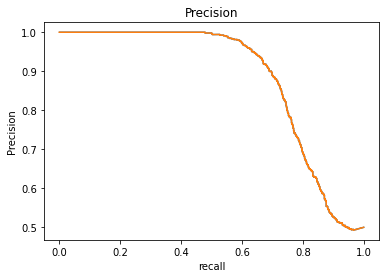

In [12]:
precision, recall, thresholds = precision_recall_curve(total_label, total_uncertainty)
plt.plot(recall[:-1],precision[:-1])
plt.title("Precision")
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("Precision")
plt.show()

In [13]:
recon_loss = []
for i in range(1000):
    loss = 0
    x_recon               = CVAE.xc_to_x_recon(x=train_t[i], c=None)
    original_hidden_value = CVAE.xc_to_h(x=train_t[i], c=None)
    recon_hidden_value    = CVAE.xc_to_h(x=x_recon, c=None)
    # recon_loss += F.mse_loss(recon_q, train_q[i])
    for i, j in zip(original_hidden_value, recon_hidden_value):
        loss += F.mse_loss(i,j)
    recon_loss.append(loss)

original_uncertainty = np.array(recon_loss).reshape(-1,1)

In [14]:
recon_loss = []
for i in range(1000):
    loss = 0
    x_recon               = CVAE.xc_to_x_recon(x=novel_q[i], c=None)
    original_hidden_value = CVAE.xc_to_h(x=novel_q[i], c=None)
    recon_hidden_value    = CVAE.xc_to_h(x=x_recon, c=None)
    # recon_loss += F.mse_loss(recon_q, train_q[i])
    for i, j in zip(original_hidden_value, recon_hidden_value):
        loss += F.mse_loss(i,j)
    recon_loss.append(loss)

novelty_uncertainty = np.array(recon_loss).reshape(-1,1)

In [15]:
total_hidden_uncertainty = np.concatenate((original_uncertainty, novelty_uncertainty),axis=0)

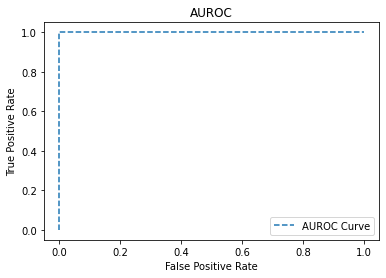

1.0


In [16]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve,auc, roc_auc_score, roc_curve 

fpr, tpr, thresholds = metrics.roc_curve(total_label, total_hidden_uncertainty)
auc = roc_auc_score(total_label, total_hidden_uncertainty)
plt.plot(fpr, tpr, linestyle='--', label='AUROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title("AUROC")
plt.show()
print(auc)

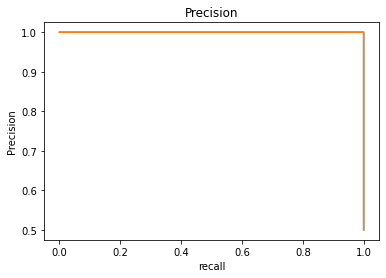

In [17]:
precision, recall, thresholds = precision_recall_curve(total_label, total_hidden_uncertainty)
plt.plot(recall[:-1],precision[:-1])
plt.title("Precision")
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("Precision")
plt.show()